In [198]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [199]:
# read and load dataset to df
df = pd.read_csv('heart.csv')
print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [ ]:
# target will include the presence or absence of heart disease features will include independent variables
target = df["HeartDisease"]
features = df.drop("HeartDisease", axis=1)

# categorical and numerical features
categoricals = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numericals = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# scale numerical features (stability) and encode categorical features
prep = ColumnTransformer([("scale",StandardScaler(),numericals),("encode",OneHotEncoder(),categoricals)])

# train test split
Xtrain, Xtest, ytrain, ytest  =  train_test_split(features, target,test_size=0.2, stratify=target, random_state=42)

# transformation
Xtrain_tr = prep.fit_transform( Xtrain ) # We are allowed to fit the normalization parameters on the training data, but not the testing data.
Xtest_tr = prep.transform( Xtest )

# conver to tensor for torch processing
Xtrain_tensor = torch.tensor(Xtrain_tr,  dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest_tr,  dtype=torch.float32)

ytrain_tensor = torch.tensor(ytrain.values.reshape(-1, 1), dtype=torch.float32)
ytest_tensor = torch.tensor(ytest.values.reshape(-1, 1), dtype=torch.float32)


In [201]:
class HeartNN(nn.Module):
    def __init__(self, input_size):
        super(HeartNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class Heart2NN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)



In [ ]:
# HeartNN training loop
n_features = X_train_tensor.shape[1]
model = HeartNN(n_features)
loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

epochs = 300
history = {"acc": [], "prec": [], "rec": [], "f1": []}

for ep in range(epochs):
    model.train()
    opt.zero_grad()

    pred_train = model(X_train_tensor)
    loss = loss_fn(pred_train, y_train_tensor)
    loss.backward()
    opt.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor).round()
        true_vals = y_test_tensor.numpy().flatten()
        pred_vals = test_pred.numpy().flatten()
        acc = accuracy_score(true_vals, pred_vals)
        prec = precision_score(true_vals, pred_vals)
        rec = recall_score(true_vals, pred_vals)
        f1 = f1_score(true_vals, pred_vals)
        print(f"Epoch {ep+1}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")
        history["acc"].append(acc)
        history["prec"].append(prec)
        history["rec"].append(rec)
        history["f1"].append(f1)

# final test predictions
model.eval()
final_out = model(X_test_tensor).round()


Epoch 1: acc=0.429, prec=0.400, rec=0.059, f1=0.103
Epoch 2: acc=0.522, prec=0.750, rec=0.206, f1=0.323
Epoch 3: acc=0.636, prec=0.843, rec=0.422, f1=0.562
Epoch 4: acc=0.745, prec=0.877, rec=0.627, f1=0.731
Epoch 5: acc=0.793, prec=0.848, rec=0.765, f1=0.804
Epoch 6: acc=0.826, prec=0.850, rec=0.833, f1=0.842
Epoch 7: acc=0.853, prec=0.850, rec=0.892, f1=0.871
Epoch 8: acc=0.853, prec=0.844, rec=0.902, f1=0.872
Epoch 9: acc=0.853, prec=0.844, rec=0.902, f1=0.872
Epoch 10: acc=0.842, prec=0.829, rec=0.902, f1=0.864
Epoch 11: acc=0.826, prec=0.807, rec=0.902, f1=0.852
Epoch 12: acc=0.821, prec=0.800, rec=0.902, f1=0.848
Epoch 13: acc=0.821, prec=0.800, rec=0.902, f1=0.848
Epoch 14: acc=0.826, prec=0.802, rec=0.912, f1=0.853
Epoch 15: acc=0.826, prec=0.802, rec=0.912, f1=0.853
Epoch 16: acc=0.837, prec=0.816, rec=0.912, f1=0.861
Epoch 17: acc=0.842, prec=0.823, rec=0.912, f1=0.865
Epoch 18: acc=0.842, prec=0.823, rec=0.912, f1=0.865
Epoch 19: acc=0.842, prec=0.823, rec=0.912, f1=0.865
Ep

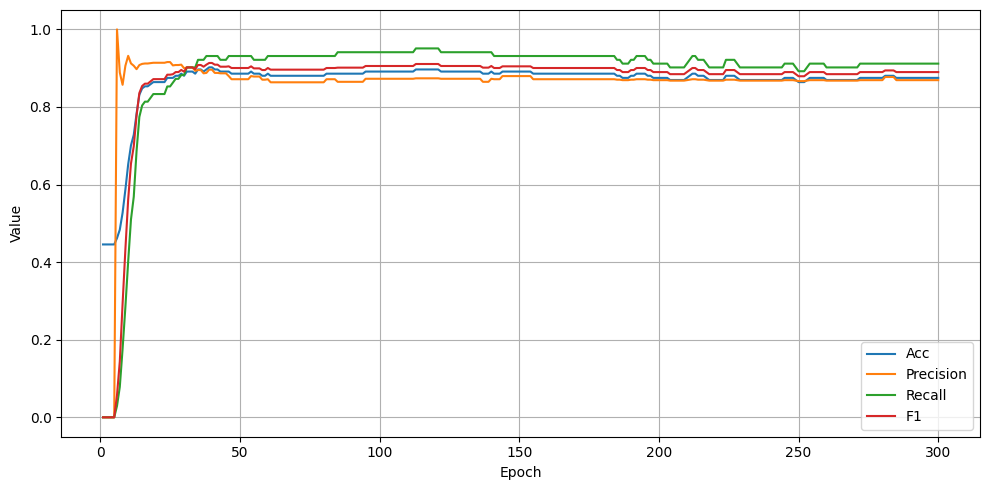

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 301, 1)
plot_df = pd.DataFrame({
    "epoch": list(epochs_range),
    "acc": history["acc"],
    "prec": history["prec"],
    "rec": history["rec"],
    "f1": history["f1"]
})

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(plot_df["epoch"], plot_df["acc"], label="Acc")
ax.plot(plot_df["epoch"], plot_df["prec"],  label="Precision")
ax.plot(plot_df["epoch"], plot_df["rec"],  label="Recall")
ax.plot(plot_df["epoch"], plot_df["f1"], label="F1")

ax.set_xlabel("Epoch")
ax.set_ylabel("Value")
ax.legend(loc="lower right")
ax.grid(True)

plt.tight_layout()
plt.show()


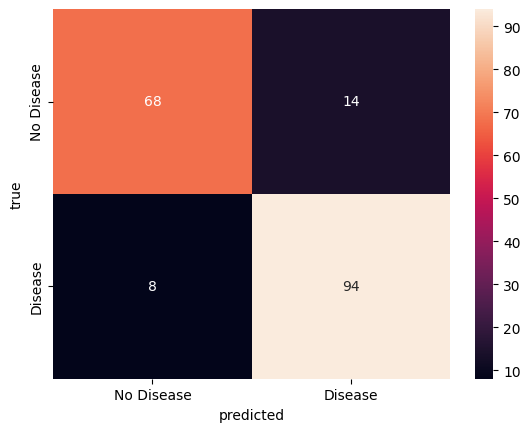

In [205]:
cm = confusion_matrix(y_test_tensor.detach().numpy(), final_out.detach().numpy())

sns.heatmap(cm, annot=True,xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

In [ ]:
# Heart2NN training loop
n_features = X_train_tensor.shape[1]
model = Heart2NN(n_features)
loss_fn = nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

epochs = 300
history = {"acc": [], "prec": [], "rec": [], "f1": []}

for ep in range(epochs):
    model.train()
    opt.zero_grad()

    pred_train = model(X_train_tensor)
    loss = loss_fn(pred_train, y_train_tensor)
    loss.backward()
    opt.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor).round()
        true_vals = y_test_tensor.numpy().flatten()
        pred_vals = test_pred.numpy().flatten()
        acc = accuracy_score(true_vals, pred_vals)
        prec = precision_score(true_vals, pred_vals)
        rec = recall_score(true_vals, pred_vals)
        f1 = f1_score(true_vals, pred_vals)
        print(f"Epoch {ep+1}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")
        history["acc"].append(acc)
        history["prec"].append(prec)
        history["rec"].append(rec)
        history["f1"].append(f1)

# final test predictions
model.eval()
final_out = model(X_test_tensor).round()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epoch 1: acc=0.446, prec=0.000, rec=0.000, f1=0.000
Epoch 2: acc=0.446, prec=0.000, rec=0.000, f1=0.000
Epoch 3: acc=0.446, prec=0.000, rec=0.000, f1=0.000
Epoch 4: acc=0.446, prec=0.000, rec=0.000, f1=0.000
Epoch 5: acc=0.446, prec=0.000, rec=0.000, f1=0.000
Epoch 6: acc=0.462, prec=1.000, rec=0.029, f1=0.057
Epoch 7: acc=0.484, prec=0.889, rec=0.078, f1=0.144
Epoch 8: acc=0.527, prec=0.857, rec=0.176, f1=0.293
Epoch 9: acc=0.587, prec=0.906, rec=0.284, f1=0.433
Epoch 10: acc=0.652, prec=0.932, rec=0.402, f1=0.562
Epoch 11: acc=0.701, prec=0.912, rec=0.510, f1=0.654
Epoch 12: acc=0.728, prec=0.906, rec=0.569, f1=0.699
Epoch 13: acc=0.783, prec=0.897, rec=0.686, f1=0.778
Epoch 14: acc=0.832, prec=0.908, rec=0.775, f1=0.836
Epoch 15: acc=0.848, prec=0.911, rec=0.804, f1=0.854
Epoch 16: acc=0.853, prec=0.912, rec=0.814, f1=0.860
Epoch 17: acc=0.853, prec=0.912, rec=0.814, f1=0.860
Epoch 18: acc=0.859, prec=0.913, rec=0.824, f1=0.866
Epoch 19: acc=0.864, prec=0.914, rec=0.833, f1=0.872
Ep

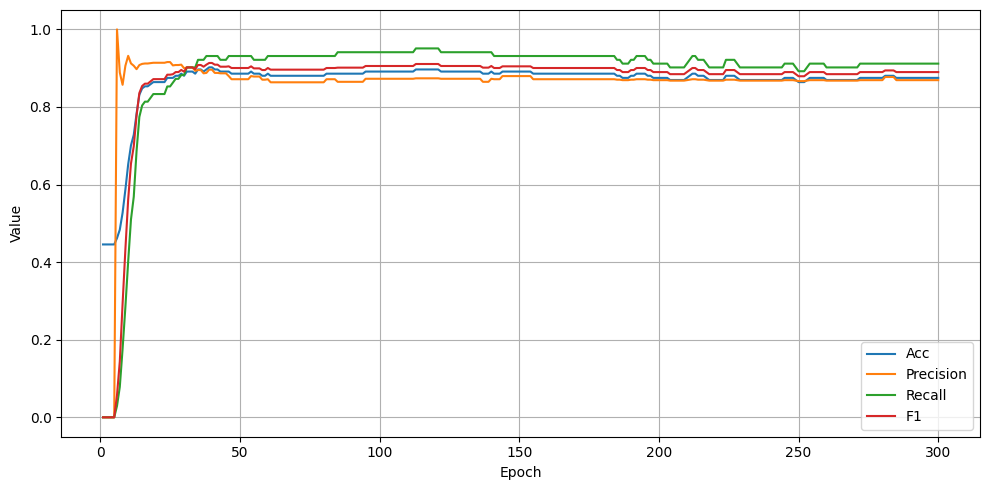

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, 301, 1)
plot_df = pd.DataFrame({
    "epoch": list(epochs_range),
    "acc": history["acc"],
    "prec": history["prec"],
    "rec": history["rec"],
    "f1": history["f1"]
})

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(plot_df["epoch"], plot_df["acc"], label="Acc")
ax.plot(plot_df["epoch"], plot_df["prec"],  label="Precision")
ax.plot(plot_df["epoch"], plot_df["rec"],  label="Recall")
ax.plot(plot_df["epoch"], plot_df["f1"], label="F1")

ax.set_xlabel("Epoch")
ax.set_ylabel("Value")
ax.legend(loc="lower right")
ax.grid(True)

plt.tight_layout()
plt.show()


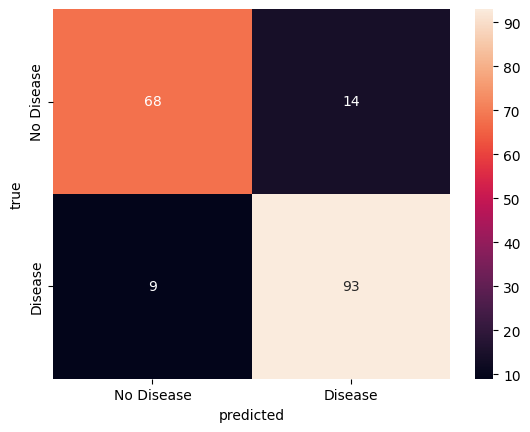

In [214]:
cm = confusion_matrix(y_test_tensor.detach().numpy(), final_out.detach().numpy())

sns.heatmap(cm, annot=True,xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()